In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from config import runs, parse_proteins_in_file

data_path = runs["smear"]

import os 
os.getcwd()

'/home/selezov_su/notebooks/Promics/Panoram'

In [3]:
def collapse(string):
    ar = string.split(";")
    if all([ar[0] == i for i in ar]):
        return ar[0]
    else:
        return string.strip(";")

    
proteins = pd.read_csv(data_path + "proteinGroups.txt", sep="\t", low_memory=False, index_col="Protein IDs")

proteins = proteins\
    .loc[proteins["Reverse"] != "+"] \
    .loc[proteins["Potential contaminant"] != "+"] \
    .loc[proteins["Only identified by site"] != "+"] 

proteins["Taxonomy names"] = proteins["Taxonomy names"].map(collapse)
proteins["Taxonomy names"].value_counts(normalize=True).head(10)

Homo sapiens                                0.808889
Veillonella sp. HPA0037                     0.034444
Candida albicans                            0.028889
Streptococcus pneumoniae TIGR4              0.022222
Prevotella sp. oral taxon 317 str. F0108    0.021111
Elaeagnaceae                                0.013333
Dorea sp. D27                               0.011111
Homo sapiens;Candida albicans               0.008889
Moraxella atlantae                          0.003333
Haemophilus influenzae Rd KW20              0.003333
Name: Taxonomy names, dtype: float64

In [4]:
proteins.columns.to_list();

In [5]:
quant_method = "iBAQ" # "LFQ" | "Intensity"

sample_consistency = 0.1
protein_consistency = 0.3

human = proteins.loc[proteins["Taxonomy names"].str.contains("Homo sapiens")]

whole_index = dict((idx.split(";")[0], idx) for idx in human.index)

human.index = human.index.map(lambda x: x.split(";")[0])

values = human[[ i for i in human.columns if i.find(quant_method) > -1 ][2:]].dropna(axis=0)
totals = human[[ i for i in human.columns if i.find(quant_method) > -1 ][1]].dropna()


mild = ["iBAQ P" + str(i) for i in [1, 4, 7, 10, 11, 12]]
severe = ["iBAQ P" + str(i) for i in [2, 3, 5, 6, 8, 9]]

tuples = [("Healthy" if col.find("H") > -1 else "Pneumonia", "Healthy" if col.find("H") > -1 else "Mild" if col in mild else "Severe", col) for col in values.columns]
values.columns = pd.MultiIndex.from_tuples(tuples, names=["Condition", "Acuteness", "Sample"])

non_zeros = values.T.groupby('Condition').agg(lambda x: x.ne(0).sum() / len(x)).T


## Proteins found only in case positive group
only_in_pneumonia = non_zeros\
    .loc[non_zeros.Healthy < 0.01] \
    .loc[non_zeros.Pneumonia > 0.5] \
.index.to_list()

with open("Data/only_pneumonia.txt", "w") as file:
    for each in only_in_pneumonia:
        file.write(each + "\n")


## Filter proteins
values = values.loc[
    non_zeros \
        .loc[non_zeros.Healthy > protein_consistency] \
        .loc[non_zeros.Pneumonia > protein_consistency]
    .index
]


## Filter samples
values = values.T.loc[values.ne(0).sum(0) / len(values) > sample_consistency].T
values.shape

(87, 20)

In [7]:
values.replace(0, np.nan).dropna()

Condition        Healthy                                                    \
Acuteness        Healthy                                                     
Sample          iBAQ H10     iBAQ H11    iBAQ H12      iBAQ H3     iBAQ H4   
Protein IDs                                                                  
P04259         4931600.0    2930800.0   4219800.0    6182500.0   8219900.0   
P06702       385900000.0  178540000.0  86035000.0   38522000.0  45705000.0   
P06733        32101000.0   26163000.0   4880800.0  107230000.0  18679000.0   

Condition                                                                  \
Acuteness                                                                   
Sample           iBAQ H5     iBAQ H6     iBAQ H7     iBAQ H8      iBAQ H9   
Protein IDs                                                                 
P04259         3304400.0   2262200.0   6601200.0   6133100.0    4052000.0   
P06702        97106000.0  63561000.0  65314000.0  27829000.0  134780000.0   
P06733       164190000.0  75761000.0   8046200.0   4358900.0   15694000.0   

Condition      Pneumonia                                                     \
Acuteness           Mild                                Severe                
Sample           iBAQ P1    iBAQ P10     iBAQ P11      iBAQ P2      iBAQ P3   
Protein IDs                                                                   
P04259        62647000.0   4145200.0   16987000.0   16877000.0    5101500.0   
P06702       205850000.0  77698000.0  118800000.0  142070000.0  171350000.0   
P06733         8728300.0   8050500.0   10051000.0   28038000.0    8828200.0   

Condition                                                                    
Acuteness          Mild       Severe                      Mild       Severe  
Sample          iBAQ P4      iBAQ P5      iBAQ P6      iBAQ P7      iBAQ P8  
Protein IDs                                                                  
P04259        9099300.0   11450000.0    5027900.0    7860000.0    5209200.0  
P06702       49174000.0  196100000.0  138280000.0  104490000.0  123050000.0  
P06733        2252700.0   21140000.0    3154800.0   20549000.0   55936000.0

In [26]:
raw_human = human[[ i for i in human.columns if i.find(quant_method) > -1 ][2:]].dropna(axis=0)
raw_human.columns = pd.MultiIndex.from_tuples(tuples, names=["Condition", "Acuteness", "Sample"])
raw_human.to_csv("Data/raw_human.csv", index=True, )

In [20]:
with open("Data/whole_protein_set.txt", "w") as file:
    file.write("\n".join(values.index.to_list()))

values.to_csv("Data/smears_not_normalized.csv", index=True)

np.log10(values + 1).to_csv("Data/smears_log10.csv", index=True)

Protein IDs                   A0A075B6P5    Q99880    O75592    P00338  \
Condition Acuteness Sample                                               
Healthy   Healthy   iBAQ H10    8.291147  7.606435  6.913448  7.521792   
                    iBAQ H11    7.969192  7.319085  6.604712  7.116143   
                    iBAQ H12    0.000000  0.000000  5.393437  0.000000   
                    iBAQ H3     8.368212  7.792770  7.177940  7.695175   
                    iBAQ H4     8.139060  7.059828  7.050148  6.634336   
                    iBAQ H5     8.288696  8.033384  6.847616  7.760407   
                    iBAQ H6     0.000000  6.829985  0.000000  7.017743   
                    iBAQ H7     7.229375  0.000000  5.837393  0.000000   
                    iBAQ H8     0.000000  0.000000  0.000000  5.937939   
                    iBAQ H9     8.290658  7.271214  7.277518  6.678955   
Pneumonia Mild      iBAQ P1     0.000000  7.267618  6.200440  6.978272   
                    iBAQ P10    0.000000  7.105067  5.648459  6.212933   
                    iBAQ P11    0.000000  7.363255  6.368343  6.589559   
          Severe    iBAQ P2     0.000000  7.351023  6.259594  6.708795   
                    iBAQ P3     0.000000  7.967459  6.696208  7.071330   
          Mild      iBAQ P4     7.269886  7.132228  6.252441  6.095588   
          Severe    iBAQ P5     8.333024  8.608793  7.153815  7.453609   
                    iBAQ P6     0.000000  0.000000  5.304708  0.000000   
          Mild      iBAQ P7     7.681910  7.447205  6.832796  6.802986   
          Severe    iBAQ P8     7.872809  8.225464  6.704999  7.309779   

Protein IDs                     P00450    P00738    P01009    P01023  \
Condition Acuteness Sample                                             
Healthy   Healthy   iBAQ H10  7.220056  7.677689  7.664143  7.874453   
                    iBAQ H11  7.160978  7.210800  6.275127  7.589503   
                    iBAQ H12  0.000000  5.903942  0.000000  0.000000   
                    iBAQ H3   7.239825  7.520536  7.441302  7.667107   
                    iBAQ H4   7.029221  7.683065  7.409274  7.499137   
                    iBAQ H5   7.213279  7.327931  7.179523  7.728589   
                    iBAQ H6   6.712220  7.109444  6.748583  6.945296   
                    iBAQ H7   6.007022  6.542863  6.331427  6.514242   
                    iBAQ H8   0.000000  6.025634  0.000000  0.000000   
                    iBAQ H9   6.749404  7.059677  0.000000  7.021479   
Pneumonia Mild      iBAQ P1   0.000000  0.000000  0.000000  0.000000   
                    iBAQ P10  0.000000  0.000000  0.000000  0.000000   
                    iBAQ P11  0.000000  0.000000  0.000000  0.000000   
          Severe    iBAQ P2   0.000000  0.000000  6.822057  0.000000   
                    iBAQ P3   5.817804  6.391412  6.496847  7.122642   
          Mild      iBAQ P4   5.692460  0.000000  6.027105  6.579989   
          Severe    iBAQ P5   7.463027  7.989926  8.056943  7.648028   
                    iBAQ P6   0.000000  0.000000  6.042143  0.000000   
          Mild      iBAQ P7   5.384642  6.187211  6.685581  5.823220   
          Severe    iBAQ P8   6.484300  7.389857  7.083646  7.173507   

Protein IDs                     P01024    P01036  ...    P68871    P80723  \
Condition Acuteness Sample                        ...                       
Healthy   Healthy   iBAQ H10  7.821828  7.106599  ...  7.818872  6.577859   
                    iBAQ H11  7.443482  7.337579  ...  7.828351  6.965625   
                    iBAQ H12  0.000000  6.474435  ...  0.000000  6.699933   
                    iBAQ H3   7.666855  7.694026  ...  7.910571  6.326909   
                    iBAQ H4   7.392521  7.481729  ...  7.989521  6.272329   
                    iBAQ H5   7.753483  6.774510  ...  8.407476  6.941338   
                    iBAQ H6   6.824158  7.817321  ...  6.973807  6.808933   
                    iBAQ H7   6.045167  0.000000  ...  6.426885  6.144730   
                

<Figure size 750x750 with 0 Axes>

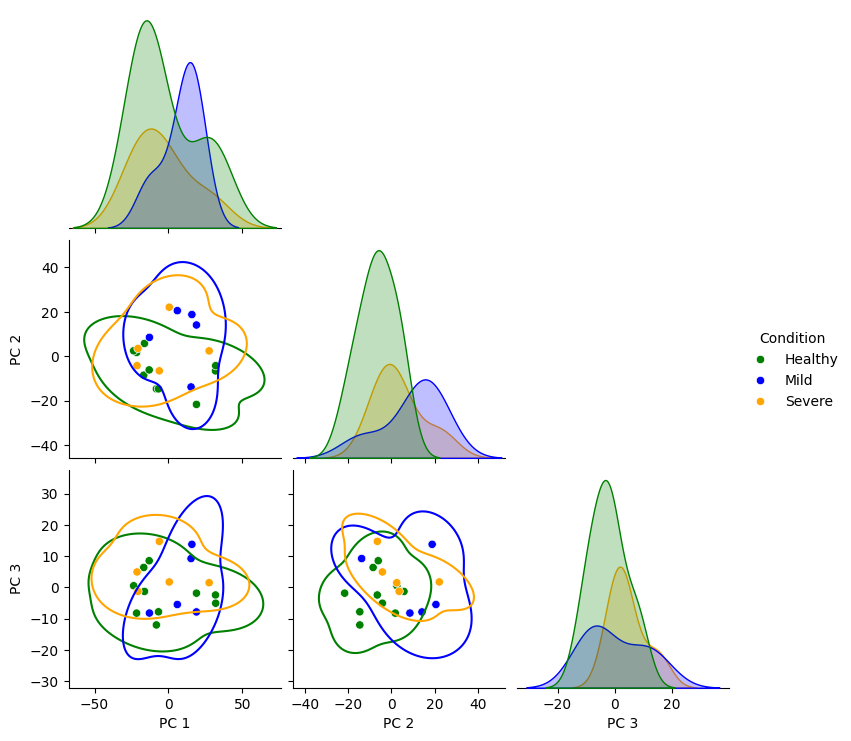

In [21]:
from sklearn.decomposition import PCA
from scipy.stats import zscore


pca_input = np.log10(values.T + 1)#.apply(zscore, axis=1)
xpca = PCA(n_components=3).fit_transform(pca_input)

pca_index = pca_input.reset_index()["Sample"]
pca_columns = [F"PC {i}" for i in range(1, xpca.shape[1] + 1)]

display(pca_input)

x_pca = pd.DataFrame(xpca, index=pca_index, columns=pca_columns)
x_pca["Condition"] = pca_input.reset_index()["Acuteness"].values


import seaborn as sns

fig = plt.figure(figsize=(7.5, 7.5))
g = sns.pairplot(x_pca, hue="Condition", palette=["green", "blue", "orange"], corner=True)
g.map_lower(sns.kdeplot, levels=1, color=".05")